이번 장에서는 신경망 학습의 핵심 개념들을 만난다. 이번 장에서 다룰 주제는 가중치 매개변수의 최적값을 탐색하는 최적화 방법, 가중치 매개변수 초깃값, 하이퍼파라미터 설정 방법 등 모두가 신경망 학습에서 중요한 주제이다. 오버피팅의 대응책인 가중치 감소와 드롭아웃 등의 정규화 방법도 간략히 설명하고 구현해본다. 

# 6.1 매개변수 갱신
신경망 학습의 목적은 손실 함수의 값을 가능한 한 낮추는 매개변수를 찾는 것이다. 이는 곧 매개변수의 최적값을 찾는 문제이며, 이러한 문제를 푸는 것을 **최적화(Optimization)**라 한다. <br><br>
우리는 지금까지 최적의 매개변수 값을 찾는 단서로 매개변수의 기울기(미분)를 이용했다. 매개변수의 기울기를 구해, 기울어진 방향으로 매개변수 값을 갱신하는 일을 몇 번이고 반복해서 점점 최적의 값에 다가갔다. 이것이 **확률적 경사 하강법(SGD)**이란 단순한 방법인데, 매개변수 공간을 무작정 찾는 것보다 '똑똑한' 방법이다. 지금부터 SGD의 단점을 알아본 후 SGD와는 다른 최적화 기법을 소개한다.

## 6.1.1 모험가 이야기
모험가는 주위 경치는 볼 수 없지만 서있는 땅의 기울기는 알 수 있다. 지금 서 있는 장소에서 가장 크게 기울어진 방향으로 가자는 것이 SGD의 전략이다.

## 6.1.2 확률적 경사 하강법(SGD)
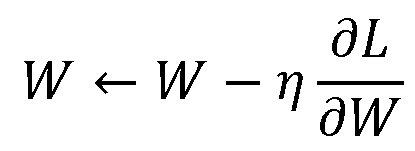